In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Dataset imports:
from data.dataset import *

# Torch imports:
import torch
import torch.nn as nn
from torch import optim
from torchvision import transforms
from torch.utils.data import Subset, DataLoader, random_split, WeightedRandomSampler
from torchvision.models import resnet50

# Model imports:
from model import *

# Train and evaluation imports:
from train import train, train2
from evaluate import evaluate, evaluate2

# Custom Transforms imports:
from custom_transforms import *

# Plotting imports:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# General imports:
import os
import json
import math
import random

# SKLearn imports:
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix

# Other imports:
from tqdm import tqdm

In [3]:
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

### Defining the device

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu'); device

device(type='cuda', index=0)

In [5]:
torch.backends.cudnn.benchmark = True

# Data preprocessing:

### Getting the mean and standard deviation of the dataset in order to apply normalization on the data:

In [6]:
# Getting the path to the .txt file that contains the mean and std:
DATA_STATS_FILE_NAME = "dataset_stats.txt"
STATS_FILE_PATH = os.path.join(os.path.dirname(os.path.abspath('__file__')), 'data', DATA_STATS_FILE_NAME)

# Reading the statistics file:
stats_dict = None
with open(STATS_FILE_PATH, 'r') as stats_file:
    stats_dict = json.loads(stats_file.read())
    
mean, std = stats_dict['mean'], stats_dict['std']

print(f'Dataset mean: \t\t\t{mean}\nDataset standard deviation: \t{std}')

Dataset mean: 			[0.4944856143767711, 0.4950292797617727, 0.4954058302766022]
Dataset standard deviation: 	[0.28984177278042145, 0.28989603043370027, 0.28941759149050483]


### Creating the preprocessing operations that the images will undergo:

In [8]:
# This Compose includes the following:
#     1) Transforms the images to tensors.
#     2) Normalized the dataset.
#     3) Sharpens the images.

# Creating the sharpness transform:
sharpen = Sharpen(sharpness_factor=2.0)
original_image_dim = (450, 600)

# Defining the new image dimension:
resize_fraction = 0.5

new_height = int(original_image_dim[0] * resize_fraction)
new_width = int(original_image_dim[1] * resize_fraction)
image_dim = (new_height, new_width)

# image_dim = (224, 224)

crop_fraction = 0.9
CROPPED_IMAGE_DIM = (int(image_dim[0] * crop_fraction), int(image_dim[0] * crop_fraction))

# train_transform = T.Compose([
#                 T.ToTensor(),
#                 T.Normalize(mean, std),
#                 T.RandomHorizontalFlip(p=0.4),
#                 T.RandomVerticalFlip(p=0.4),
#                 T.RandomGrayscale(p=0.25),
#                 T.RandomAutocontrast(p=0.2),        
#                 T.RandomApply([
# #                                 T.RandomRotation(degrees=15),
#                                 T.GaussianBlur(kernel_size=5, sigma=(0.1, 0.2)),
#                                 T.ColorJitter(brightness=0.5, hue=0.3, saturation=0.5),
#                                 T.RandomCrop(CROPPED_IMAGE_DIM, pad_if_needed=True)], p=0.30),
                
#                 T.Resize(image_dim),
#                 sharpen]    
#         )
resnext_mean = [0.485, 0.456, 0.406]
resnext_std = [0.229, 0.224, 0.225]

train_transform = T.Compose([
                T.ToTensor(),
                T.Normalize(resnext_mean, resnext_std),
#                 T.RandomHorizontalFlip(p=0.4),
#                 T.RandomVerticalFlip(p=0.4),
#                 T.RandomAutocontrast(p=0.2),        
#                 T.RandomRotation(degrees=10),
#                 T.GaussianBlur(kernel_size=5, sigma=(0.1, 0.2)),
#                 T.ColorJitter(brightness=0.5, hue=0.3, saturation=0.5),
#                 T.RandomCrop(CROPPED_IMAGE_DIM, pad_if_needed=True),
                T.RandomApply([
                    T.RandomHorizontalFlip(p=0.7),
                    T.RandomVerticalFlip(p=0.7),
                    T.RandomRotation(degrees=10),
                    T.RandomGrayscale(p=0.3),
                    T.GaussianBlur(kernel_size=5, sigma=(0.1, 0.2))
                ], p=0.5),
                T.Resize(image_dim),
                sharpen]    
        )

val_transform = T.Compose([
                T.ToTensor(),      
                T.Normalize(resnext_mean, resnext_std),
                T.Resize(image_dim),
                sharpen]    
)

image_preprocessing = T.Compose([
                T.ToTensor(),      
                T.Normalize(mean, std),
                T.Resize(image_dim),
                sharpen]    
)

In [9]:
image_dim

(225, 300)

# Defining the dataset:

In [9]:
# Creating the dataset instance:
test_dataset = SkinCancerDataset(transform=image_preprocessing)

### The dataset class distribution:

In [24]:
data_dist = test_dataset.get_data_distribution()
data_dist

{'akiec': 327,
 'bcc': 514,
 'bkl': 1099,
 'df': 115,
 'mel': 1113,
 'nv': 6705,
 'vasc': 142}

### Plotting the data distribution:

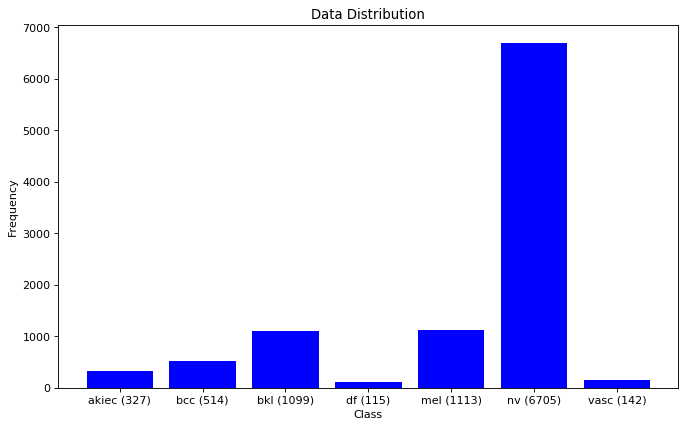

In [25]:
figure(figsize=(10, 6), dpi=80)
plt.title('Data Distribution')

y = list(data_dist.values())
x = [f'{label} ({count})' for label, count in zip(data_dist.keys(), data_dist.values())]

plt.xlabel("Class")
plt.ylabel("Frequency")
plt.bar(x, y, color='b')

plt.show()

# Overfitting Experiment:

### Creating a subset for training:

In [11]:
SUBSET_SIZE = 100
selected_class = 2
sample_array_1 = test_dataset.get_class_indecies(selected_class)

selected_class = 4
sample_array_2 = test_dataset.get_class_indecies(selected_class)

selected_class = 0
sample_array_3 = test_dataset.get_class_indecies(selected_class)

sample_array = sample_array_1 + sample_array_2 + sample_array_3

subset_indicies = np.random.choice(sample_array, SUBSET_SIZE, replace=False)
train_subset = Subset(test_dataset, subset_indicies)

In [12]:
subset_loader = DataLoader(train_subset, shuffle=True, batch_size=32, num_workers=8)

### Creating the model:

In [13]:
model_overfit = Model(num_classes=7, image_dim=image_dim, dropout_prob=[0,0,0])

### The hyperparameters, the loss function and the optimizer:

In [14]:
learning_rate = 6e-4

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_overfit.parameters(), lr=learning_rate)

In [15]:
epochs = 25

### Overfitting the model:

In [16]:
total_loss, epoch_durations, accuracies_train, accuracies_validation = train(model=model_overfit,
                                                                            train_loader=subset_loader,
                                                                            validation_loader=subset_loader,
                                                                            criterion=criterion,
                                                                            optimizer=optimizer,
                                                                            epochs=epochs,
                                                                            verbose=True)

  0%|          | 0/25 [00:00<?, ?it/s]

Evaluating epoch...


  4%|▍         | 1/25 [00:25<10:14, 25.62s/it]

Epoch: 0 | Train_acc: 23.00% | Val_acc: 23.00% | Loss: 11.42 | Runtime: 25.62 seconds
Evaluating epoch...


  8%|▊         | 2/25 [00:48<09:05, 23.72s/it]

Epoch: 1 | Train_acc: 48.00% | Val_acc: 48.00% | Loss: 17.89 | Runtime: 22.39 seconds
Evaluating epoch...


 12%|█▏        | 3/25 [01:09<08:22, 22.84s/it]

Epoch: 2 | Train_acc: 55.00% | Val_acc: 55.00% | Loss: 10.58 | Runtime: 21.80 seconds
Evaluating epoch...


 16%|█▌        | 4/25 [01:31<07:50, 22.42s/it]

Epoch: 3 | Train_acc: 51.00% | Val_acc: 51.00% | Loss: 2.69 | Runtime: 21.78 seconds
Evaluating epoch...


 20%|██        | 5/25 [01:53<07:23, 22.20s/it]

Epoch: 4 | Train_acc: 67.00% | Val_acc: 67.00% | Loss: 3.15 | Runtime: 21.80 seconds
Evaluating epoch...


 24%|██▍       | 6/25 [02:15<06:59, 22.06s/it]

Epoch: 5 | Train_acc: 67.00% | Val_acc: 67.00% | Loss: 3.79 | Runtime: 21.78 seconds
Evaluating epoch...


 28%|██▊       | 7/25 [02:36<06:35, 21.97s/it]

Epoch: 6 | Train_acc: 73.00% | Val_acc: 73.00% | Loss: 3.04 | Runtime: 21.79 seconds
Evaluating epoch...


 32%|███▏      | 8/25 [02:58<06:13, 21.97s/it]

Epoch: 7 | Train_acc: 74.00% | Val_acc: 74.00% | Loss: 2.99 | Runtime: 21.98 seconds
Evaluating epoch...


 36%|███▌      | 9/25 [03:20<05:50, 21.93s/it]

Epoch: 8 | Train_acc: 78.00% | Val_acc: 78.00% | Loss: 2.33 | Runtime: 21.84 seconds
Evaluating epoch...


 40%|████      | 10/25 [03:42<05:28, 21.88s/it]

Epoch: 9 | Train_acc: 80.00% | Val_acc: 80.00% | Loss: 1.98 | Runtime: 21.78 seconds
Evaluating epoch...


 44%|████▍     | 11/25 [04:04<05:05, 21.79s/it]

Epoch: 10 | Train_acc: 84.00% | Val_acc: 84.00% | Loss: 2.12 | Runtime: 21.58 seconds
Evaluating epoch...


 48%|████▊     | 12/25 [04:25<04:42, 21.74s/it]

Epoch: 11 | Train_acc: 83.00% | Val_acc: 83.00% | Loss: 1.63 | Runtime: 21.61 seconds
Evaluating epoch...


 52%|█████▏    | 13/25 [04:47<04:21, 21.75s/it]

Epoch: 12 | Train_acc: 85.00% | Val_acc: 85.00% | Loss: 1.51 | Runtime: 21.78 seconds
Evaluating epoch...


 56%|█████▌    | 14/25 [05:09<04:00, 21.82s/it]

Epoch: 13 | Train_acc: 83.00% | Val_acc: 83.00% | Loss: 1.64 | Runtime: 21.99 seconds
Evaluating epoch...


 60%|██████    | 15/25 [05:31<03:38, 21.81s/it]

Epoch: 14 | Train_acc: 87.00% | Val_acc: 87.00% | Loss: 1.82 | Runtime: 21.78 seconds
Evaluating epoch...


 64%|██████▍   | 16/25 [05:53<03:16, 21.81s/it]

Epoch: 15 | Train_acc: 91.00% | Val_acc: 91.00% | Loss: 2.04 | Runtime: 21.80 seconds
Evaluating epoch...


 68%|██████▊   | 17/25 [06:14<02:54, 21.80s/it]

Epoch: 16 | Train_acc: 93.00% | Val_acc: 93.00% | Loss: 1.07 | Runtime: 21.79 seconds
Evaluating epoch...


 72%|███████▏  | 18/25 [06:36<02:32, 21.74s/it]

Epoch: 17 | Train_acc: 88.00% | Val_acc: 88.00% | Loss: 1.03 | Runtime: 21.59 seconds
Evaluating epoch...


 76%|███████▌  | 19/25 [06:58<02:10, 21.75s/it]

Epoch: 18 | Train_acc: 90.00% | Val_acc: 90.00% | Loss: 1.05 | Runtime: 21.79 seconds
Evaluating epoch...


 80%|████████  | 20/25 [07:20<01:48, 21.77s/it]

Epoch: 19 | Train_acc: 96.00% | Val_acc: 96.00% | Loss: 0.72 | Runtime: 21.81 seconds
Evaluating epoch...


 84%|████████▍ | 21/25 [07:41<01:26, 21.71s/it]

Epoch: 20 | Train_acc: 98.00% | Val_acc: 98.00% | Loss: 0.65 | Runtime: 21.58 seconds
Evaluating epoch...


 88%|████████▊ | 22/25 [08:02<01:04, 21.50s/it]

Epoch: 21 | Train_acc: 99.00% | Val_acc: 99.00% | Loss: 0.52 | Runtime: 21.01 seconds
Evaluating epoch...


 92%|█████████▏| 23/25 [08:23<00:42, 21.40s/it]

Epoch: 22 | Train_acc: 98.00% | Val_acc: 98.00% | Loss: 0.41 | Runtime: 21.15 seconds
Evaluating epoch...


 96%|█████████▌| 24/25 [08:45<00:21, 21.34s/it]

Epoch: 23 | Train_acc: 98.00% | Val_acc: 98.00% | Loss: 0.53 | Runtime: 21.20 seconds
Evaluating epoch...


100%|██████████| 25/25 [09:07<00:00, 21.89s/it]

Epoch: 24 | Train_acc: 100.00% | Val_acc: 100.00% | Loss: 0.38 | Runtime: 22.23 seconds


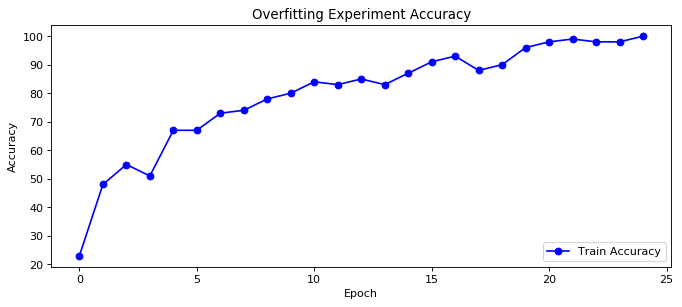

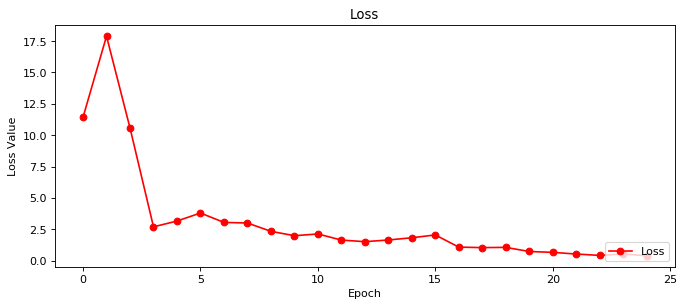

In [17]:
# --- Accuracy: ------------------------------------------------

figure(figsize=(10, 4), dpi=80)
plt.title('Overfitting Experiment Accuracy')

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(accuracies_train, 'bo-')
plt.legend(["Train Accuracy"], loc ="lower right")
plt.show()

# --- Loss: ----------------------------------------------------

figure(figsize=(10, 4), dpi=80)

plt.title('Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss Value")
plt.plot(total_loss, 'ro-')
plt.legend(["Loss"], loc ="lower right")
plt.show()

# =============================================================

# Setting up the actual model:

### Defining the Dataset object:

In [10]:
dataset = SkinCancerDataset()

### Splitting the dataset into train, validation, and test sets:

In [11]:
# Defining the proportions of how the dataset will be split:
train_proportion = 0.6
validation_proportion = 0.2
test_proportion = 0.2

# Defining all possible indecies to create a dataset with:
all_indecies = np.arange(len(dataset))

# --- Defining the sizes of the splits: ----------------------------------------------

# 1) The train set size:
train_size = math.ceil(train_proportion * len(all_indecies)) - 3000

# 2) The validation set size:
validation_size = math.ceil(validation_proportion * len(all_indecies))

# 3) The test set size:
test_size = math.floor(test_proportion * len(all_indecies))

np.random.shuffle(all_indecies)

# --- Defining the indecies for each split: ------------------------------------------
train_set_ind = np.copy(all_indecies[0: train_size])
val_set_ind = np.copy(all_indecies[train_size : train_size + validation_size])
test_set_ind = np.copy(all_indecies[train_size + validation_size : train_size + validation_size + test_size])

# --- Defining the train, validation, and test sets: ---------------------------------
class_threshold = 3000
train_set = SkinCancerDataset(transform=train_transform, indecies=train_set_ind, class_threshold=class_threshold)
validation_set = SkinCancerDataset(transform=val_transform, indecies=val_set_ind)
test_set = SkinCancerDataset(transform=val_transform, indecies=test_set_ind)

### Saving the test set so it can be used again for evaluation:

In [12]:
# Defining the path where the test indecies will be saved:
save_path = os.path.join(os.path.dirname(os.path.abspath('__file__')), 'data', 'test_split_indecies_2.txt')

with open(save_path, 'w') as file:
    test_dict = {'test_indecies' : str(list(test_set_ind))}
    json_dump = json.dumps(test_dict)
    file.write(json_dump)

## Plotting the train data distribution before augmentation of all the splits

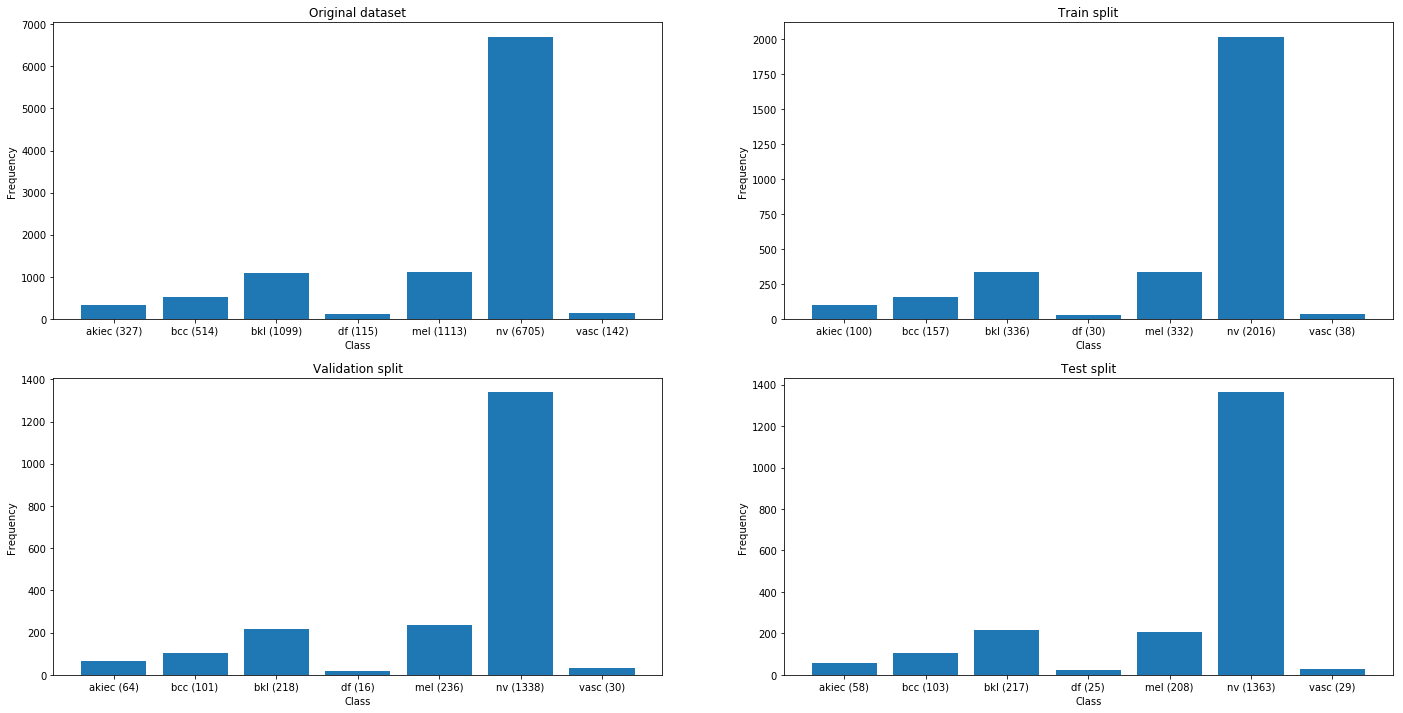

In [13]:
fig, axarr = plt.subplots(2, 2)

fig_size = 12

fig.set_figwidth(fig_size * 2)
fig.set_figheight(fig_size)

titles = ['Original dataset', 'Train split', 'Validation split', 'Test split']
splits = [dataset, train_set, validation_set, test_set]

for ax, split, title in zip(axarr.flatten(), splits, titles):
    data_dist = split.get_data_distribution()
    
    y = list(data_dist.values())
    x = [f'{label} ({count})' for label, count in data_dist.items()]
    
    ax.set_title(title)
    
    ax.set_xlabel('Class')
    ax.set_ylabel('Frequency')
    ax.bar(x, y)
    

# Visualizing the preprocessed and the original data:

In [14]:
train_original = SkinCancerDataset(indecies=train_set_ind)
train_preprocessed = SkinCancerDataset(transform=image_preprocessing, indecies=train_set_ind)

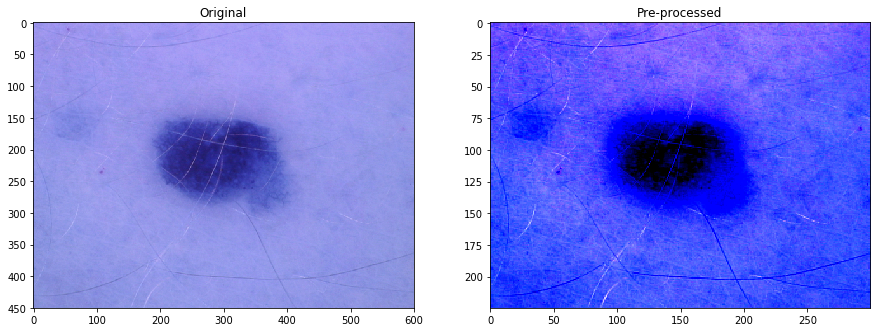

In [15]:
fig, axarr = plt.subplots(1,2)

fig.set_figheight(15)
fig.set_figwidth(15)

index = random.randint(0, len(train_original))

# Retrieving the images:
original_image = train_original[index][0]
preprocessed_image = train_preprocessed[index][0]

# Converting the images to numpy arrays so they can be plotted by matplotlib:
original_image = np.transpose(original_image.cpu().detach().numpy(), (1, 2, 0))
preprocessed_image = np.transpose(preprocessed_image.cpu().detach().numpy(), (1, 2, 0))

axarr[0].set_title('Original')
axarr[1].set_title('Pre-processed')

axarr[0].imshow(original_image)
axarr[1].imshow(preprocessed_image)

# Oversampling the data:

This will be done using the weighted random sampler in PyTorch

### 1) Calculating the weights for the sampler

In [16]:
# Calculating the weights of each class:
weights = np.array(list(train_set.get_data_distribution().values()))
weights = 1 / weights

# Assiging the weights to the images:
image_weights = [weights[i] for i in train_set.mapped_labels]

### Plotting the weights of each class:

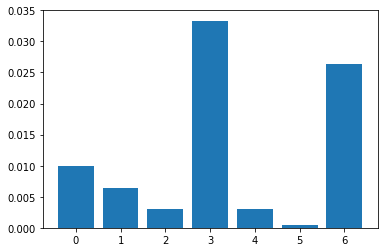

In [17]:
plt.bar(np.arange(dataset.number_of_classes), weights)
plt.show()

### 2) Creating the sampler:

In [18]:
sampler = WeightedRandomSampler(weights=image_weights, num_samples=len(train_set), replacement=True)

# Augmenting the training data:

### Finding the number of data to be augmented for each class:

In [17]:
augmentation_amount = np.array([class_threshold - i for i in data_dist.values()])
print(f'Number of data points to be augmented: {sum(augmentation_amount)}')
augmentation_amount

Number of data points to be augmented: 19498


array([2958, 2939, 2829, 2982, 2823, 1980, 2987], dtype=int64)

### Creating a new dataset object with augmeted images:

In [40]:
train_set = SkinCancerDataset(transform=image_preprocessing, indecies=train_set_ind, augment=True, class_threshold=3000)

### Showing the new data distribution:

In [41]:
data_dist = train_set.get_data_distribution()
data_dist

{'akiec': 2880,
 'bcc': 2790,
 'bkl': 2572,
 'df': 2944,
 'mel': 2585,
 'nv': 2661,
 'vasc': 2934}

### The size of the dataset after augmetation:

In [50]:
len(train_set)

3009

# Plotting the data distribution after the augmentation:

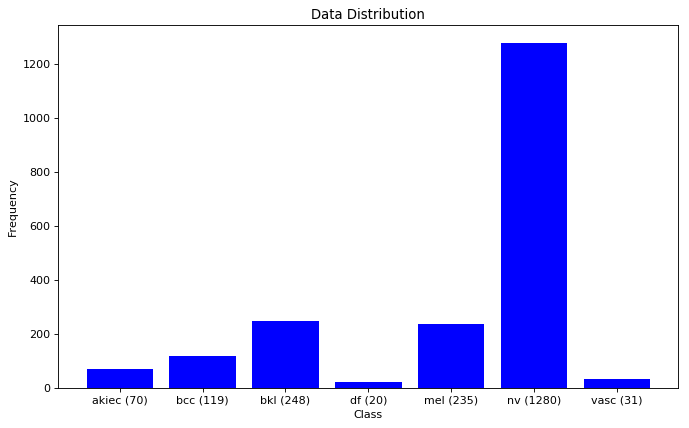

In [51]:
figure(figsize=(10, 6), dpi=80)
plt.title('Data Distribution')

y = list(data_dist.values())
x = [f'{label} ({count})' for label, count in zip(data_dist.keys(), data_dist.values())]

plt.xlabel("Class")
plt.ylabel("Frequency")
plt.bar(x, y, color='b')

plt.show()

# Visualizing the a random subset of the train images after augmentation:

### Getting the sample:

In [19]:
sample_size = 16
index_subsample = np.random.choice(range(len(train_set_ind)), sample_size)

### Plotting the images:

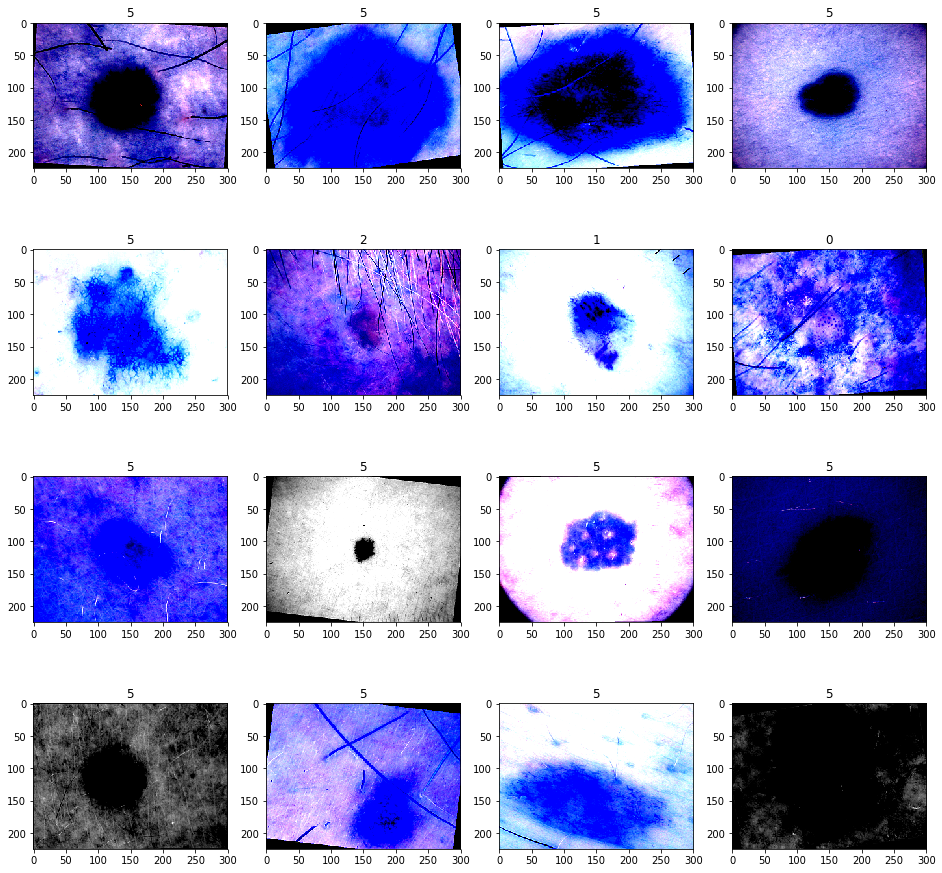

In [20]:
fig, axarr = plt.subplots(4, 4)

fig_size = 16

fig.set_figheight(fig_size)
fig.set_figwidth(fig_size)

for ax, ind in zip(axarr.flatten(), index_subsample):
    # Getting the image:
    image = train_set[ind][0]
    # Converting the image to numpy and applying transpose on its
    # dimension so it can be plotted by matplotlib:
    image = np.transpose(image.cpu().detach().numpy(), (1, 2, 0))
    # Getting the image label and id:
    label = train_set[ind][1]
    title = f'{label}'
    
    ax.set_title(title)
    ax.imshow(image)

### Creating the DataLoader objects:

In [21]:
train_batch_size, validation_batch_size, test_batch_size = 64, 64, 64

# Setting the num_workers to the number of cores on this machine.
num_workers = 8

# train_loader = DataLoader(train_set, shuffle=True, batch_size=train_batch_size, num_workers=num_workers, pin_memory=True)
train_loader = DataLoader(train_set, shuffle=sampler, batch_size=train_batch_size, num_workers=num_workers, pin_memory=True)
validation_loader = DataLoader(validation_set, shuffle=True, batch_size=validation_batch_size, num_workers=num_workers, pin_memory=True)
test_loader = DataLoader(test_set, shuffle=False, batch_size=test_batch_size, num_workers=num_workers, pin_memory=True)

# Creating the model:

In [22]:
# model = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b4', pretrained=True)
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnext50_32x4d', pretrained=True)

Using cache found in C:\Users\abooo/.cache\torch\hub\pytorch_vision_v0.10.0


### Freezing all the parameters:

In [23]:
# Iterating over al the model parameters and setting requires_grad to False
for param in model.parameters():
    param.requires_grad = False

### Modifying the last fully-connected layer to fit the Skin cancer dataset:

In [64]:
# Getting the number of input features of the fully-conncted layer in order to use it
# for the new fully-conntected layer:
in_features = model.classifier.fc.in_features

# Modifying the last fully-connected layer:
model.classifier.fc = torch.nn.Linear(in_features=in_features, out_features=dataset.number_of_classes)

AttributeError: 'ResNet' object has no attribute 'classifier'

In [24]:
# Getting the number of input features of the fully-conncted layer in order to use it
# for the new fully-conntected layer:
in_features = model.fc.in_features

# Modifying the last fully-connected layer:
model.fc = torch.nn.Linear(in_features=in_features, out_features=dataset.number_of_classes)

### Defining the optimizer, criterion, and hyperparameters:

[0.63730051 0.61477251 0.54119752 0.66415514 0.54287415 0.06466829
 0.66113537]


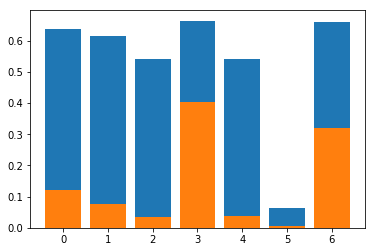

In [26]:
learning_rate = 6e-3
weight_decay = 1e-8

# --- Defining the optimizer: ---------------------------------------------------------
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
# optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

# Defining the learning rate schedular:
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=23, gamma=0.1)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[40], gamma=0.1)

base_lr = 1e-8
max_lr = 1e-3

optimizer = optim.SGD(model.parameters(), lr=base_lr, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.CyclicLR(optimizer, base_lr=base_lr, max_lr=max_lr,
                                        step_size_up=train_batch_size//2,
                                        step_size_down=train_batch_size//2)
# scheduler = None
 
# --- Defining the loss function: -----------------------------------------------------
data_dist = np.array(list(train_set.get_data_distribution().values()))
class_weights = 1  / data_dist
class_weights = class_weights / np.sum(class_weights)


f = lambda a, m, x: 1 / (1 + np.exp((m - x) / a))
x = class_weights
m, a = np.min(x), - 0.9
x = (data_dist - np.mean(data_dist)) / np.std(data_dist)
weights = f(a, m, x)

# class_weights = torch.Tensor(class_weights).to(device)
# criterion = nn.CrossEntropyLoss(weight=class_weights).to(device)
# class_weights
print(weights)
plt.bar(np.arange(7), weights)
plt.bar(np.arange(7), class_weights)
plt.show()

# weights = torch.Tensor(weights).to(device)
# criterion = nn.CrossEntropyLoss(weight=weights).to(device)
criterion = nn.CrossEntropyLoss()

### Defining the number of epochs:

In [27]:
epochs = 70

# Training the model

In [28]:
total_loss, epoch_durations, accuracies_train, accuracies_validation = train2(model=model,
                                                                            train_loader=train_loader,
                                                                            validation_loader=validation_loader,
                                                                            criterion=criterion,
                                                                            optimizer=optimizer,
                                                                            scheduler=scheduler,
                                                                            epochs=epochs,
                                                                            verbose=True)

  0%|          | 0/70 [00:00<?, ?it/s]

Evaluating epoch...


  1%|▏         | 1/70 [01:01<1:11:17, 62.00s/it]

Learning rate: 1e-08
Epoch: 0 | Train_acc: 5.98% | Val_acc: 5.89% | Loss: 95.13 | Runtime: 62.00 seconds
Evaluating epoch...


  3%|▎         | 2/70 [01:57<1:05:36, 57.89s/it]

Learning rate: 3.1259687500000004e-05
Epoch: 1 | Train_acc: 67.00% | Val_acc: 66.80% | Loss: 66.72 | Runtime: 55.02 seconds
Evaluating epoch...


  4%|▍         | 3/70 [02:53<1:03:44, 57.09s/it]

Learning rate: 6.2509375e-05
Epoch: 2 | Train_acc: 67.00% | Val_acc: 66.80% | Loss: 56.72 | Runtime: 56.13 seconds
Evaluating epoch...


  6%|▌         | 4/70 [03:49<1:02:29, 56.81s/it]

Learning rate: 9.37590625e-05
Epoch: 3 | Train_acc: 67.00% | Val_acc: 66.80% | Loss: 52.81 | Runtime: 56.39 seconds
Evaluating epoch...


  7%|▋         | 5/70 [04:45<1:01:07, 56.43s/it]

Learning rate: 0.00012500875
Epoch: 4 | Train_acc: 67.00% | Val_acc: 66.80% | Loss: 51.27 | Runtime: 55.75 seconds
Evaluating epoch...


  9%|▊         | 6/70 [05:40<59:55, 56.18s/it]  

Learning rate: 0.0001562584375
Epoch: 5 | Train_acc: 67.00% | Val_acc: 66.80% | Loss: 50.09 | Runtime: 55.69 seconds
Evaluating epoch...


 10%|█         | 7/70 [06:37<59:08, 56.33s/it]

Learning rate: 0.000187508125
Epoch: 6 | Train_acc: 67.00% | Val_acc: 66.80% | Loss: 49.14 | Runtime: 56.64 seconds
Evaluating epoch...


 11%|█▏        | 8/70 [07:33<57:57, 56.09s/it]

Learning rate: 0.0002187578125
Epoch: 7 | Train_acc: 67.00% | Val_acc: 66.85% | Loss: 47.98 | Runtime: 55.58 seconds
Evaluating epoch...


 13%|█▎        | 9/70 [08:28<56:55, 55.99s/it]

Learning rate: 0.0002500075
Epoch: 8 | Train_acc: 67.10% | Val_acc: 67.15% | Loss: 47.22 | Runtime: 55.77 seconds
Evaluating epoch...


 14%|█▍        | 10/70 [09:24<55:52, 55.87s/it]

Learning rate: 0.0002812571875
Epoch: 9 | Train_acc: 67.23% | Val_acc: 67.45% | Loss: 46.29 | Runtime: 55.59 seconds
Evaluating epoch...


 16%|█▌        | 11/70 [10:21<55:15, 56.20s/it]

Learning rate: 0.000312506875
Epoch: 10 | Train_acc: 67.86% | Val_acc: 68.25% | Loss: 45.39 | Runtime: 56.94 seconds
Evaluating epoch...


 17%|█▋        | 12/70 [11:17<54:16, 56.15s/it]

Learning rate: 0.00034375656250000005
Epoch: 11 | Train_acc: 67.83% | Val_acc: 68.35% | Loss: 45.45 | Runtime: 56.04 seconds
Evaluating epoch...


 19%|█▊        | 13/70 [12:13<53:11, 55.99s/it]

Learning rate: 0.00037500625
Epoch: 12 | Train_acc: 68.43% | Val_acc: 68.50% | Loss: 43.71 | Runtime: 55.62 seconds
Evaluating epoch...


 20%|██        | 14/70 [13:10<52:38, 56.40s/it]

Learning rate: 0.0004062559375
Epoch: 13 | Train_acc: 68.69% | Val_acc: 68.60% | Loss: 43.09 | Runtime: 57.35 seconds
Evaluating epoch...


 21%|██▏       | 15/70 [14:06<51:38, 56.34s/it]

Learning rate: 0.00043750562500000003
Epoch: 14 | Train_acc: 69.23% | Val_acc: 68.75% | Loss: 42.88 | Runtime: 56.20 seconds
Evaluating epoch...


 23%|██▎       | 16/70 [15:03<50:43, 56.37s/it]

Learning rate: 0.00046875531250000006
Epoch: 15 | Train_acc: 69.23% | Val_acc: 69.10% | Loss: 42.15 | Runtime: 56.42 seconds
Evaluating epoch...


 24%|██▍       | 17/70 [15:59<49:40, 56.23s/it]

Learning rate: 0.0005000050000000001
Epoch: 16 | Train_acc: 70.09% | Val_acc: 69.65% | Loss: 41.34 | Runtime: 55.92 seconds
Evaluating epoch...


 26%|██▌       | 18/70 [16:54<48:37, 56.11s/it]

Learning rate: 0.0005312546875000001
Epoch: 17 | Train_acc: 69.92% | Val_acc: 70.29% | Loss: 41.94 | Runtime: 55.82 seconds
Evaluating epoch...


 27%|██▋       | 19/70 [17:50<47:37, 56.03s/it]

Learning rate: 0.000562504375
Epoch: 18 | Train_acc: 69.56% | Val_acc: 69.90% | Loss: 41.70 | Runtime: 55.83 seconds
Evaluating epoch...


 29%|██▊       | 20/70 [18:46<46:42, 56.05s/it]

Learning rate: 0.0005937540625000001
Epoch: 19 | Train_acc: 70.85% | Val_acc: 70.54% | Loss: 40.95 | Runtime: 56.10 seconds
Evaluating epoch...


 30%|███       | 21/70 [19:42<45:46, 56.06s/it]

Learning rate: 0.0006250037500000001
Epoch: 20 | Train_acc: 70.69% | Val_acc: 70.54% | Loss: 40.80 | Runtime: 56.07 seconds
Evaluating epoch...


 31%|███▏      | 22/70 [20:38<44:48, 56.01s/it]

Learning rate: 0.0006562534375000001
Epoch: 21 | Train_acc: 70.16% | Val_acc: 70.64% | Loss: 39.63 | Runtime: 55.91 seconds
Evaluating epoch...


 33%|███▎      | 23/70 [21:33<43:33, 55.61s/it]

Learning rate: 0.0006875031250000002
Epoch: 22 | Train_acc: 70.92% | Val_acc: 70.14% | Loss: 39.06 | Runtime: 54.65 seconds
Evaluating epoch...


 34%|███▍      | 24/70 [22:28<42:36, 55.57s/it]

Learning rate: 0.0007187528125000001
Epoch: 23 | Train_acc: 71.45% | Val_acc: 71.19% | Loss: 39.08 | Runtime: 55.49 seconds
Evaluating epoch...


 36%|███▌      | 25/70 [23:25<41:53, 55.86s/it]

Learning rate: 0.0007500025000000001
Epoch: 24 | Train_acc: 72.28% | Val_acc: 70.69% | Loss: 41.27 | Runtime: 56.52 seconds
Evaluating epoch...


 37%|███▋      | 26/70 [24:20<40:48, 55.65s/it]

Learning rate: 0.0007812521875000001
Epoch: 25 | Train_acc: 71.98% | Val_acc: 71.04% | Loss: 41.12 | Runtime: 55.17 seconds
Evaluating epoch...


 39%|███▊      | 27/70 [25:16<39:57, 55.75s/it]

Learning rate: 0.0008125018750000001
Epoch: 26 | Train_acc: 72.58% | Val_acc: 71.39% | Loss: 40.76 | Runtime: 56.00 seconds
Evaluating epoch...


 40%|████      | 28/70 [26:12<39:06, 55.87s/it]

Learning rate: 0.0008437515625000001
Epoch: 27 | Train_acc: 72.22% | Val_acc: 71.89% | Loss: 39.58 | Runtime: 56.12 seconds
Evaluating epoch...


 41%|████▏     | 29/70 [27:07<37:56, 55.53s/it]

Learning rate: 0.0008750012500000001
Epoch: 28 | Train_acc: 73.08% | Val_acc: 71.84% | Loss: 39.80 | Runtime: 54.74 seconds
Evaluating epoch...


 43%|████▎     | 30/70 [28:02<36:56, 55.42s/it]

Learning rate: 0.0009062509375000001
Epoch: 29 | Train_acc: 72.85% | Val_acc: 70.89% | Loss: 40.99 | Runtime: 55.17 seconds
Evaluating epoch...


 44%|████▍     | 31/70 [28:58<36:03, 55.46s/it]

Learning rate: 0.0009375006250000002
Epoch: 30 | Train_acc: 72.62% | Val_acc: 72.04% | Loss: 37.97 | Runtime: 55.56 seconds
Evaluating epoch...


 46%|████▌     | 32/70 [29:53<35:02, 55.33s/it]

Learning rate: 0.0009687503125000002
Epoch: 31 | Train_acc: 73.18% | Val_acc: 71.24% | Loss: 36.76 | Runtime: 55.01 seconds
Evaluating epoch...


 47%|████▋     | 33/70 [30:48<34:04, 55.26s/it]

Learning rate: 0.001
Epoch: 32 | Train_acc: 72.81% | Val_acc: 70.24% | Loss: 37.66 | Runtime: 55.11 seconds
Evaluating epoch...


 49%|████▊     | 34/70 [31:43<33:06, 55.19s/it]

Learning rate: 0.0009687503125000002
Epoch: 33 | Train_acc: 72.95% | Val_acc: 71.04% | Loss: 37.62 | Runtime: 55.02 seconds
Evaluating epoch...


 50%|█████     | 35/70 [32:38<32:15, 55.29s/it]

Learning rate: 0.0009375006250000002
Epoch: 34 | Train_acc: 73.25% | Val_acc: 71.54% | Loss: 36.80 | Runtime: 55.53 seconds
Evaluating epoch...


 51%|█████▏    | 36/70 [33:34<31:20, 55.32s/it]

Learning rate: 0.0009062509375000001
Epoch: 35 | Train_acc: 74.38% | Val_acc: 71.99% | Loss: 38.53 | Runtime: 55.38 seconds
Evaluating epoch...


 53%|█████▎    | 37/70 [34:31<30:41, 55.81s/it]

Learning rate: 0.0008750012500000001
Epoch: 36 | Train_acc: 72.78% | Val_acc: 70.89% | Loss: 37.50 | Runtime: 56.95 seconds
Evaluating epoch...


 54%|█████▍    | 38/70 [35:29<30:13, 56.66s/it]

Learning rate: 0.0008437515625000001
Epoch: 37 | Train_acc: 74.18% | Val_acc: 71.89% | Loss: 37.17 | Runtime: 58.66 seconds
Evaluating epoch...


 56%|█████▌    | 39/70 [36:27<29:23, 56.89s/it]

Learning rate: 0.0008125018750000001
Epoch: 38 | Train_acc: 73.68% | Val_acc: 72.04% | Loss: 35.82 | Runtime: 57.40 seconds
Evaluating epoch...


 57%|█████▋    | 40/70 [37:24<28:30, 57.01s/it]

Learning rate: 0.0007812521875000001
Epoch: 39 | Train_acc: 74.24% | Val_acc: 71.09% | Loss: 36.16 | Runtime: 57.29 seconds
Evaluating epoch...


 59%|█████▊    | 41/70 [38:21<27:31, 56.93s/it]

Learning rate: 0.0007500025000000001
Epoch: 40 | Train_acc: 72.88% | Val_acc: 71.74% | Loss: 35.96 | Runtime: 56.76 seconds
Evaluating epoch...


 60%|██████    | 42/70 [39:18<26:34, 56.96s/it]

Learning rate: 0.0007187528125000001
Epoch: 41 | Train_acc: 73.88% | Val_acc: 71.59% | Loss: 35.11 | Runtime: 57.01 seconds
Evaluating epoch...


 61%|██████▏   | 43/70 [40:14<25:31, 56.72s/it]

Learning rate: 0.0006875031250000002
Epoch: 42 | Train_acc: 73.78% | Val_acc: 71.79% | Loss: 36.61 | Runtime: 56.16 seconds
Evaluating epoch...


 63%|██████▎   | 44/70 [41:11<24:39, 56.90s/it]

Learning rate: 0.0006562534375000001
Epoch: 43 | Train_acc: 73.68% | Val_acc: 71.79% | Loss: 35.31 | Runtime: 57.33 seconds
Evaluating epoch...


 64%|██████▍   | 45/70 [42:09<23:45, 57.03s/it]

Learning rate: 0.0006250037500000001
Epoch: 44 | Train_acc: 73.51% | Val_acc: 71.89% | Loss: 36.37 | Runtime: 57.33 seconds
Evaluating epoch...


 66%|██████▌   | 46/70 [43:06<22:52, 57.20s/it]

Learning rate: 0.0005937540625000001
Epoch: 45 | Train_acc: 73.81% | Val_acc: 71.99% | Loss: 38.16 | Runtime: 57.60 seconds
Evaluating epoch...


 67%|██████▋   | 47/70 [44:04<22:01, 57.44s/it]

Learning rate: 0.000562504375
Epoch: 46 | Train_acc: 73.98% | Val_acc: 72.09% | Loss: 37.35 | Runtime: 57.99 seconds
Evaluating epoch...


 69%|██████▊   | 48/70 [45:01<20:56, 57.14s/it]

Learning rate: 0.0005312546875000001
Epoch: 47 | Train_acc: 74.54% | Val_acc: 71.94% | Loss: 36.06 | Runtime: 56.43 seconds
Evaluating epoch...


 70%|███████   | 49/70 [45:58<20:00, 57.17s/it]

Learning rate: 0.0005000050000000001
Epoch: 48 | Train_acc: 74.54% | Val_acc: 72.24% | Loss: 34.66 | Runtime: 57.24 seconds
Evaluating epoch...


 71%|███████▏  | 50/70 [46:55<19:04, 57.24s/it]

Learning rate: 0.00046875531250000006
Epoch: 49 | Train_acc: 74.34% | Val_acc: 71.99% | Loss: 35.20 | Runtime: 57.41 seconds
Evaluating epoch...


 73%|███████▎  | 51/70 [47:52<18:02, 57.00s/it]

Learning rate: 0.00043750562500000003
Epoch: 50 | Train_acc: 74.78% | Val_acc: 71.94% | Loss: 35.87 | Runtime: 56.43 seconds
Evaluating epoch...


 74%|███████▍  | 52/70 [48:49<17:08, 57.14s/it]

Learning rate: 0.0004062559375
Epoch: 51 | Train_acc: 74.38% | Val_acc: 72.19% | Loss: 34.67 | Runtime: 57.47 seconds
Evaluating epoch...


 76%|███████▌  | 53/70 [49:46<16:07, 56.93s/it]

Learning rate: 0.00037500625
Epoch: 52 | Train_acc: 74.61% | Val_acc: 71.84% | Loss: 34.01 | Runtime: 56.43 seconds
Evaluating epoch...


 77%|███████▋  | 54/70 [50:43<15:12, 57.06s/it]

Learning rate: 0.00034375656250000005
Epoch: 53 | Train_acc: 74.21% | Val_acc: 72.19% | Loss: 33.79 | Runtime: 57.35 seconds
Evaluating epoch...


 79%|███████▊  | 55/70 [51:40<14:15, 57.03s/it]

Learning rate: 0.000312506875
Epoch: 54 | Train_acc: 74.11% | Val_acc: 72.29% | Loss: 34.16 | Runtime: 56.97 seconds
Evaluating epoch...


 80%|████████  | 56/70 [52:38<13:21, 57.28s/it]

Learning rate: 0.0002812571875
Epoch: 55 | Train_acc: 74.54% | Val_acc: 71.84% | Loss: 35.92 | Runtime: 57.85 seconds
Evaluating epoch...


 81%|████████▏ | 57/70 [53:35<12:25, 57.32s/it]

Learning rate: 0.0002500075
Epoch: 56 | Train_acc: 74.38% | Val_acc: 71.64% | Loss: 33.74 | Runtime: 57.41 seconds
Evaluating epoch...


 83%|████████▎ | 58/70 [54:32<11:25, 57.15s/it]

Learning rate: 0.0002187578125
Epoch: 57 | Train_acc: 74.58% | Val_acc: 72.19% | Loss: 33.72 | Runtime: 56.77 seconds
Evaluating epoch...


 84%|████████▍ | 59/70 [55:29<10:27, 57.09s/it]

Learning rate: 0.000187508125
Epoch: 58 | Train_acc: 74.41% | Val_acc: 72.44% | Loss: 33.88 | Runtime: 56.94 seconds
Evaluating epoch...


 86%|████████▌ | 60/70 [56:26<09:31, 57.20s/it]

Learning rate: 0.0001562584375
Epoch: 59 | Train_acc: 75.11% | Val_acc: 72.34% | Loss: 34.62 | Runtime: 57.44 seconds
Evaluating epoch...


 87%|████████▋ | 61/70 [57:23<08:34, 57.12s/it]

Learning rate: 0.00012500875
Epoch: 60 | Train_acc: 74.24% | Val_acc: 72.09% | Loss: 35.09 | Runtime: 56.94 seconds
Evaluating epoch...


 89%|████████▊ | 62/70 [58:21<07:37, 57.19s/it]

Learning rate: 9.37590625e-05
Epoch: 61 | Train_acc: 74.88% | Val_acc: 72.34% | Loss: 33.81 | Runtime: 57.36 seconds
Evaluating epoch...


 90%|█████████ | 63/70 [59:17<06:39, 57.01s/it]

Learning rate: 6.2509375e-05
Epoch: 62 | Train_acc: 74.31% | Val_acc: 72.39% | Loss: 33.76 | Runtime: 56.57 seconds
Evaluating epoch...


 91%|█████████▏| 64/70 [1:00:15<05:43, 57.26s/it]

Learning rate: 3.1259687500000004e-05
Epoch: 63 | Train_acc: 74.64% | Val_acc: 72.34% | Loss: 33.64 | Runtime: 57.84 seconds
Evaluating epoch...


 93%|█████████▎| 65/70 [1:01:17<04:53, 58.63s/it]

Learning rate: 1e-08
Epoch: 64 | Train_acc: 75.21% | Val_acc: 72.34% | Loss: 33.33 | Runtime: 61.82 seconds
Evaluating epoch...


 94%|█████████▍| 66/70 [1:02:18<03:57, 59.36s/it]

Learning rate: 3.1259687500000004e-05
Epoch: 65 | Train_acc: 74.98% | Val_acc: 72.14% | Loss: 33.86 | Runtime: 61.06 seconds
Evaluating epoch...


 96%|█████████▌| 67/70 [1:03:19<02:59, 59.79s/it]

Learning rate: 6.2509375e-05
Epoch: 66 | Train_acc: 74.34% | Val_acc: 72.39% | Loss: 37.38 | Runtime: 60.79 seconds
Evaluating epoch...


 97%|█████████▋| 68/70 [1:04:21<02:00, 60.40s/it]

Learning rate: 9.37590625e-05
Epoch: 67 | Train_acc: 74.28% | Val_acc: 72.39% | Loss: 33.65 | Runtime: 61.84 seconds
Evaluating epoch...


 99%|█████████▊| 69/70 [1:05:21<01:00, 60.41s/it]

Learning rate: 0.00012500875
Epoch: 68 | Train_acc: 74.68% | Val_acc: 71.69% | Loss: 34.47 | Runtime: 60.42 seconds
Evaluating epoch...


100%|██████████| 70/70 [1:06:23<00:00, 56.90s/it]

Learning rate: 0.0001562584375
Epoch: 69 | Train_acc: 74.61% | Val_acc: 72.29% | Loss: 33.47 | Runtime: 61.51 seconds


## Plotting the train and validation accuracies:

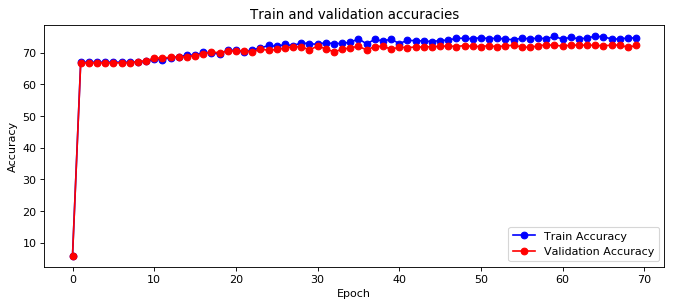

In [29]:
figure(figsize=(10, 4), dpi=80)
plt.title('Train and validation accuracies')

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(accuracies_train, 'bo-')
plt.plot(accuracies_validation, 'ro-')

plt.legend(["Train Accuracy", "Validation Accuracy"], loc ="lower right")
plt.show()

## Plotting the loss:

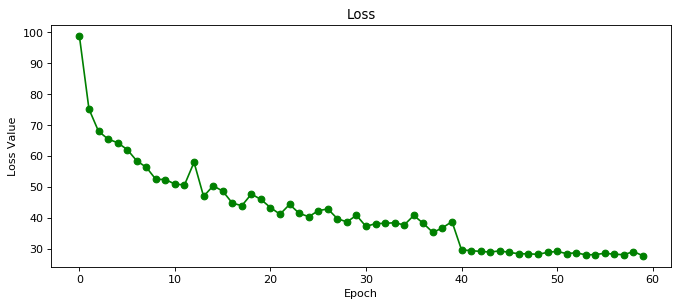

In [31]:
figure(figsize=(10, 4), dpi=80)

plt.title('Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss Value")

plt.plot(total_loss, 'go-')

plt.show()

# Evaluating the model with the test set:

In [25]:
test_accuracy = evaluate2(model=model, data_loader=test_loader, device=device)

In [26]:
print(f'Test accuracy: {test_accuracy:.2f}%')

Test accuracy: 73.70%


# Visualizing the model:

## 1) Visualizing the filters:

### Getting the filters from the model:

In [ ]:
def visTensor(tensor, ch=0, allkernels=False, nrow=8, padding=1): 
    n,c,w,h = tensor.shape

    if allkernels: tensor = tensor.view(n*c, -1, w, h)
    elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)

    rows = np.min((tensor.shape[0] // nrow + 1, 64))    
    grid = utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
    plt.figure(figsize=(nrow,rows) )
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

In [ ]:
# Moving the model to the cpu:
vis_model = model.to('cpu')

filters = []

# Iterating over the layers:
for layer in vis_model.module_list:
    # Iterating over the operations in each layer:
    for op in layer:
        if isinstance(op, torch.nn.Conv2d):
            f = op.weight.data.clone()
            filters.append(f)
            visTensor(f, ch=0, allkernels=False)
            
plt.axis('off')
plt.ioff()
plt.show()

## 2) Visualizing a convolved random filter with a random image:

In [ ]:
# Getting the filter:
f = filters[0]

# Getting a random image from the test dataset:
index = random.randint(0, len(test_set))
rand_image = test_set[index][0]
rand_image = rand_image.view(1, *rand_image.shape)

# Convolving the image with the filter:
conv_im = nn.functional.conv2d(rand_image, f)

# Showing the original image and the convolved image:
fig, axarr = plt.subplots(1, 2)

fig_size = 14

fig.set_figwidth(fig_size)
fig.set_figheight(fig_size)


image = rand_image.cpu().detach().numpy().squeeze()
image = np.transpose(image, (1, 2, 0))

axarr[0].set_title('Original')
axarr[1].set_title('Convolved')

axarr[0].imshow(image)
axarr[1].imshow(conv_im[:, 0, :, :].squeeze())

## 3) Visualizing a convolved image with all the filters:

In [ ]:
height, width = 64, 4
fig, axarr = plt.subplots(height, width)

# fig.tight_layout()
fig_size = 64

fig.set_figheight(fig_size)
fig.set_figwidth(fig_size)

conv_im = rand_image
ind = 0
for conv_num, f in enumerate(filters):
    conv_im = nn.functional.conv2d(conv_im, f)
    
    for i in range(f.shape[0]):
        im = conv_im[:, i, :, :].squeeze()
        im = im.cpu().detach().numpy()
        
        ax = axarr.flatten()[ind]
        ax.set_title(f'conv_{conv_num}')
        ax.imshow(im)
        ind += 1

# Class Accuracies

In [27]:
model = model.to(device)

nb_classes = 7
preds_list = []
confusion_mat = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in tqdm(enumerate(test_loader)):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs.float())
        _, preds = torch.max(outputs, 1)
        for item in preds:
            preds_list.append(item.item())
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_mat[t.long(), p.long()] += 1

47it [00:09,  5.06it/s]


In [28]:
classes = np.unique(test_set.labels)

class_accuracies = confusion_mat.diag() / confusion_mat.sum(1)
class_acc_dict = dict(zip(classes, class_accuracies.tolist()))

for cls, accuracy in class_acc_dict.items():
    print(f'{cls}: {100 * accuracy:.2f}%')

akiec: 36.17%
bcc: 53.52%
bkl: 57.98%
df: 46.15%
mel: 32.56%
nv: 88.31%
vasc: 26.32%


In [29]:
ground_truth = test_set.mapped_labels

In [30]:
preds_list = np.array(preds_list)

### Printing the confusion matrix:

In [31]:
conf_mat = confusion_matrix(ground_truth, preds_list)

In [32]:
print(conf_mat)

[[ 17  11   7   0   7   5   0]
 [  5  38  10   0   4  13   1]
 [  6  17 109   1  19  36   0]
 [  0   0   2   6   3   2   0]
 [  5   6  26   1  56  77   1]
 [  6  16  48   3  40 876   3]
 [  0   2   1   0   0  11   5]]


### Testing the model with precision, recall, and f1-score:

In [38]:
print(classification_report(ground_truth, preds_list))

              precision    recall  f1-score   support

           0       0.42      0.26      0.32        42
           1       0.47      0.57      0.52        61
           2       0.53      0.50      0.52       171
           3       0.00      0.00      0.00        18
           4       0.51      0.31      0.39       177
           5       0.84      0.93      0.88      1020
           6       0.42      0.38      0.40        13

    accuracy                           0.76      1502
   macro avg       0.46      0.42      0.43      1502
weighted avg       0.73      0.76      0.74      1502



# Saving the model:

### Creating the path in which the model will be saved:

In [ ]:
path = os.getcwd()
model_name = f'skin_cancer_model_v2'

In [ ]:
MODEL_PATH = os.path.join(path, model_name)

### Saving the model:

In [ ]:
# torch.save(model.state_dict(), MODEL_PATH)